### 이 파일이 이미지로 점수 예측하는 코드입니다. 

# 0. 실행할 부분

In [1]:
# torchvision 관련 라이브러리 import

from torchvision import utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

/nfs/home/dailyavenger/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install jsonlines
!pip install pdf2image

In [3]:
#@title

import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models



In [4]:
#@title
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import glob
from PIL import Image
import jsonlines
import os
from tqdm import tqdm

#1. 데이터셋 로드


In [5]:
#@title
import cv2,io

class PaperDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        years = ["2021"]
        for year in years:
            cnt = 0
            year_image_path = overall_image_path
            # year_image_path = overall_image_path+"iclr"+year+"/"
            # *********** 경로 수정 ***********
            with jsonlines.open(f"iclr{year}_metadata.jsonl") as read_file:
                for line in read_file.iter():
                    rating_dict[line['forum']] = line['rating']
            input_paths = os.listdir(year_image_path)
            ignore_4 = True
            ignore_5 = True
            ignore_6 = True
            for one_file_image_path in tqdm(input_paths, desc="make data set"):
               
                image_path = year_image_path + one_file_image_path + "/"
                rating = rating_dict[one_file_image_path]
                iter=1
                rating_int = int(rating)
                if rating_int==2:
                  iter = 20
                elif rating_int==3:
                  iter = 2
                elif rating_int==7:
                  iter = 2
                elif rating_int==8:
                  iter = 20

                elif rating_int==4:
                  if ignore_4:
                    iter = 0
                    ignore_4 = False
                  else:
                    ignore_4 = True

                elif rating_int==5:
                  if ignore_5:
                    iter = 0
                    ignore_5 = False
                  else:
                    ignore_5 = True

                elif rating_int==6:
                  if ignore_6:
                    iter = 0
                    ignore_6 = False
                  else:
                    ignore_6 = True
                    

                for _ in range(iter): 
                    before_add_size = len(self.image_list)
                    self.image_list.extend(glob.glob(image_path + "*.bin")) # glob: 폴더 내의 파일 찾아줌   
                    self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
                
                
            print(f"{year}: {cnt}")

    def __len__(self):
        return len(self.image_list)


    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 

        for i in range(0,224):
            for j in range(0,224):
                for b in range(0,3):
                    if(i<=11):
                        img[i][j][b]=255

        if self.transform is not None:
            img = self.transform(img)
        
        return img, label
        
    def get__score_list(self):
        return self.score_list

In [6]:
image_path =  "../wngusrud27/dataset/image/iclr2021/" 
image_path2 =  "temp/" 
dataset_file_name = 'iclr2021_dataset.pt'

In [7]:
#zip_path = image_path + "iclr2021_binary.zip"

#!mkdir binary

#!cp {zip_path} ./iclr2021.zip

#!unzip -q ./iclr2021.zip -d ./binary/ 

#!rm ./iclr2021.zip

In [8]:
def make_save_data_set(image_path2, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = PaperDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, image_path2 + dataset_file_name)
  print("save data sets")

In [9]:
#image_path =  "./binary/" 
make_save_data_set(image_path2, dataset_file_name)
# data_set_usage_ex(dataset_file_name)

start to make data set
initialize data sets


make data set: 100%|██████████| 2594/2594 [00:00<00:00, 4972.80it/s]

2021: 0
data set length: 20781
save data sets


In [10]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(image_path2+dataset_file_name)

train_size = int(0.8 * len(dataset))
print("train size:", train_size)

test_size = len(dataset) - train_size
print("test size:", test_size)
# validation 
train_dataset, test_dataset = random_split(dataset, [train_size,test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

train size: 16624
test size: 4157


In [11]:
score_list = dataset.get__score_list()
lst = [0]*10
for score in score_list:
  score_int = int(score)
  lst[score_int] +=1
print(lst)

[0, 0, 2340, 2358, 2466, 4176, 3447, 3474, 2520, 0]


# 2 모델 생성,하이퍼 파라미터 설정

In [12]:
from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=False).to(device) # true 옵션으로 사전 학습된 모델을 로드

# transfer learning 사용 시 추가 
# if using_transfer_learning:|
#   for param in resnet50.parameters():
#     param.requires_grad = False

def create_model(input_channel, using_transfer_learning=True):
  
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")
  resnet50 = models.resnet50(pretrained=using_transfer_learning).to(device)
  if input_channel != 3:
    old_layer = resnet50.conv1
    
    # Creating a new Conv2d layer
    new_layer = nn.Conv2d(in_channels=input_channel, # 3 -> input_channel
                      out_channels=old_layer.out_channels, # 64
                      kernel_size=old_layer.kernel_size, # (7, 7)
                      stride=old_layer.stride, # (2, 2)
                      padding=old_layer.padding, # (3, 3)
                      bias=old_layer.bias) # False
    if using_transfer_learning:
      for channel in range(3, input_channel, 3):
        new_layer.weight[:, channel:channel+3, :, :] = old_layer.weight[:, 0:3, : :].clone()
    with torch.no_grad():
      # Copying the weights from the old to the new layer
      new_layer.weight[:, 0:3, :, :] = old_layer.weight.clone()
      
    new_layer.weight = nn.Parameter(new_layer.weight, requires_grad=(not using_transfer_learning))
  
    resnet50.conv1 = new_layer
  if using_transfer_learning:
    for param in resnet50.parameters():
      param.requires_grad = False
  # model = nn.Sequential(
  #     resnet50,
  #     nn.Flatten(),
  #     nn.Linear(1000, 256),
  #     nn.ReLU(),
  #     nn.Linear(256, 32),
  #     nn.ReLU(),
  #     nn.Linear(32, 1)
  # ).to(device)
  old_fc_in_features = resnet50.fc.in_features # = 2048
  resnet50.fc = nn.Linear(old_fc_in_features, 1)
  return resnet50.to(device)
  # return model


<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/tmp/ipykernel_3026380/4267760019.py:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(input_channel % 3 == 0, "The number of channels needs to be a multiple of 3")


In [13]:
import torch
import torch.nn as nn
from torch import optim
lr = 0.0001
num_epochs = 10
model=create_model(3,True)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.MSELoss().to(device)

In [14]:
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_dataloader,
    'test_dataloader': test_dataloader,
    'device':device
}

# 3. 학습

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [16]:
import time
import datetime
from numpy import vstack

def train(model, params):
  total_start = time.time()
  loss_function=params["loss_function"]
  train_dataloader=params["train_dataloader"]
  test_dataloader=params["test_dataloader"]
  device=params["device"]

  print("start train")
  print("train size:", train_size)
  print("test size:", test_size)
  min_loss=999999
  average_total=0
  average_accuracy=0
  for epoch in range(0, num_epochs):

    model.train()
    epoch_start = time.time()
    trained_number = 0
    for i, data in enumerate(train_dataloader, 0):
        
        # train dataloader 로 불러온 데이터에서 이미지와 라벨을 분리
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        
        # 이전 batch에서 계산된 가중치를 초기화
      optimizer.zero_grad() 
        # forward + back propagation 연산
      outputs = model(inputs).squeeze()
      train_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32))
      train_loss.backward()
      optimizer.step()
      trained_number += labels.size(0)
        
      if i%100==0:
        print(f"epoch {epoch+1} {trained_number/train_size*100}% train finish")
    print(f"epoch {epoch+1} train finish") 

  

    model.eval()
      # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    correct2 = 0 
    
    score_list = list()   ##새로 추가
    predict_list = list()
    

    for i, data in enumerate(test_dataloader, 0):
        
      inputs, labels = data        
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)
        

        # 결과값 연산
      outputs = model(inputs).squeeze()
      score_list.extend(labels.detach().cpu().numpy()) ##새로 추가
      predict_list.extend(outputs.detach().cpu().numpy())## 새로추가

      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      correct2 += (abs(outputs - labels)).sum().item()
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss
      if i%50==0:
        print(f"epoch {epoch+1} {total/test_size*100}% test finish")
        # break
    
    import matplotlib.pyplot as plt ##새로 추가
    plt.scatter(score_list,predict_list) ##새로 추가 .numpy()
    plt.xlabel('evaluation score')
    plt.ylabel('predicted score')
    plt.show()
    plt.savefig(f"my_plot4_{epoch}.png")
    plt.close()
      # 학습 결과 출력
    print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f, difference: %.6f' %(epoch+1, num_epochs, train_loss.item(), loss/total, 100*correct/total, correct2/total)) #, correct2/total
    average_total+= loss/total
    average_accuracy+=100*correct/total
    if(min_loss > loss/total):
      min_loss=loss/total
      torch.save(model.state_dict(), f"temp/model{epoch}" )

  average_total/=num_epochs 
  average_accuracy/=num_epochs
  print("min loss:", min_loss)
  print("average_loss:", average_total)
  print("average_accuracy:", average_accuracy)    
    #epoch_elapsed_time = time.time() - epoch_start
    #epoch_elapsed_time_list = str(datetime.timedelta(seconds=epoch_elapsed_time)).split(".")
    #total_elapsed_time = time.time() - total_start
    #total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    #print(f"Epoch {epoch+1} Elapsed time is {epoch_elapsed_time_list[0]}")  
    #print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  


start train
train size: 16624
test size: 4157


/tmp/ipykernel_3026380/3518189860.py:79: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype=np.uint8)


epoch 1 0.0962463907603465% train finish
epoch 1 9.720885466794996% train finish
epoch 1 19.345524542829644% train finish
epoch 1 28.97016361886429% train finish
epoch 1 38.59480269489894% train finish
epoch 1 48.21944177093359% train finish
epoch 1 57.84408084696824% train finish
epoch 1 67.46871992300288% train finish
epoch 1 77.09335899903753% train finish
epoch 1 86.71799807507219% train finish
epoch 1 96.34263715110684% train finish
epoch 1 train finish
epoch 1 0.38489295164782295% test finish
epoch 1 19.62954053403897% test finish
epoch 1 38.87418811643012% test finish
epoch 1 58.11883569882127% test finish
epoch 1 77.36348328121241% test finish
epoch 1 96.60813086360356% test finish


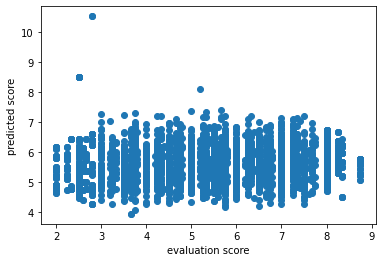

Epoch: 1/10, Train loss: 3.989445, Test loss: 3.196555, Accuracy: 19.49, difference: 1.482150
epoch 2 0.0962463907603465% train finish
epoch 2 9.720885466794996% train finish
epoch 2 19.345524542829644% train finish
epoch 2 28.97016361886429% train finish
epoch 2 38.59480269489894% train finish
epoch 2 48.21944177093359% train finish
epoch 2 57.84408084696824% train finish
epoch 2 67.46871992300288% train finish
epoch 2 77.09335899903753% train finish
epoch 2 86.71799807507219% train finish
epoch 2 96.34263715110684% train finish
epoch 2 train finish
epoch 2 0.38489295164782295% test finish
epoch 2 19.62954053403897% test finish
epoch 2 38.87418811643012% test finish
epoch 2 58.11883569882127% test finish
epoch 2 77.36348328121241% test finish
epoch 2 96.60813086360356% test finish


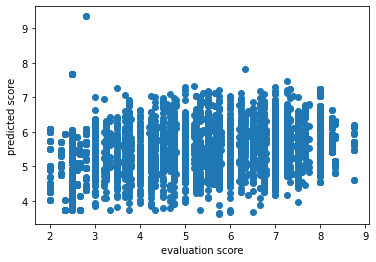

Epoch: 2/10, Train loss: 2.455912, Test loss: 2.818513, Accuracy: 19.77, difference: 1.401128
epoch 3 0.0962463907603465% train finish
epoch 3 9.720885466794996% train finish
epoch 3 19.345524542829644% train finish
epoch 3 28.97016361886429% train finish
epoch 3 38.59480269489894% train finish
epoch 3 48.21944177093359% train finish
epoch 3 57.84408084696824% train finish
epoch 3 67.46871992300288% train finish
epoch 3 77.09335899903753% train finish
epoch 3 86.71799807507219% train finish
epoch 3 96.34263715110684% train finish
epoch 3 train finish
epoch 3 0.38489295164782295% test finish
epoch 3 19.62954053403897% test finish
epoch 3 38.87418811643012% test finish
epoch 3 58.11883569882127% test finish
epoch 3 77.36348328121241% test finish
epoch 3 96.60813086360356% test finish


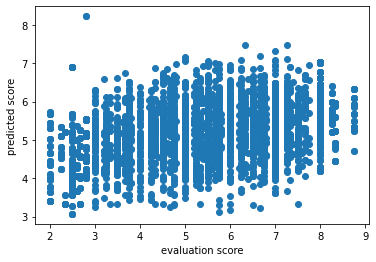

Epoch: 3/10, Train loss: 2.836861, Test loss: 2.712361, Accuracy: 18.11, difference: 1.386709
epoch 4 0.0962463907603465% train finish
epoch 4 9.720885466794996% train finish
epoch 4 19.345524542829644% train finish
epoch 4 28.97016361886429% train finish
epoch 4 38.59480269489894% train finish
epoch 4 48.21944177093359% train finish
epoch 4 57.84408084696824% train finish
epoch 4 67.46871992300288% train finish
epoch 4 77.09335899903753% train finish
epoch 4 86.71799807507219% train finish
epoch 4 96.34263715110684% train finish
epoch 4 train finish
epoch 4 0.38489295164782295% test finish
epoch 4 19.62954053403897% test finish
epoch 4 38.87418811643012% test finish
epoch 4 58.11883569882127% test finish
epoch 4 77.36348328121241% test finish
epoch 4 96.60813086360356% test finish


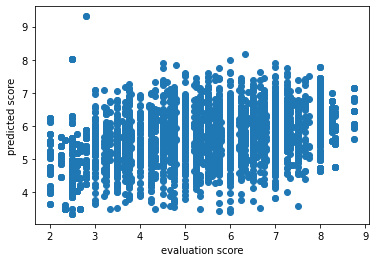

Epoch: 4/10, Train loss: 2.536892, Test loss: 2.610112, Accuracy: 20.42, difference: 1.340906
epoch 5 0.0962463907603465% train finish
epoch 5 9.720885466794996% train finish
epoch 5 19.345524542829644% train finish
epoch 5 28.97016361886429% train finish
epoch 5 38.59480269489894% train finish
epoch 5 48.21944177093359% train finish
epoch 5 57.84408084696824% train finish
epoch 5 67.46871992300288% train finish
epoch 5 77.09335899903753% train finish
epoch 5 86.71799807507219% train finish
epoch 5 96.34263715110684% train finish
epoch 5 train finish
epoch 5 0.38489295164782295% test finish
epoch 5 19.62954053403897% test finish
epoch 5 38.87418811643012% test finish
epoch 5 58.11883569882127% test finish
epoch 5 77.36348328121241% test finish
epoch 5 96.60813086360356% test finish


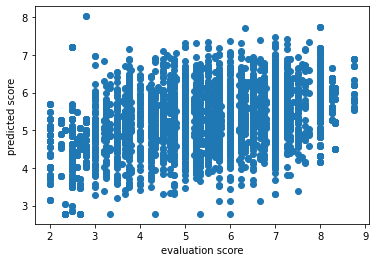

Epoch: 5/10, Train loss: 1.571011, Test loss: 2.502125, Accuracy: 20.76, difference: 1.326880
epoch 6 0.0962463907603465% train finish
epoch 6 9.720885466794996% train finish
epoch 6 19.345524542829644% train finish


KeyboardInterrupt: 

: 

In [17]:
import gc
gc.collect()              
torch.cuda.empty_cache()
train(model, params)

In [ ]:

from torchsummary import summary

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
+=1

SyntaxError: invalid syntax (1170883156.py, line 1)

## 테스트

In [ ]:
#@title
import cv2
class TestDataSet(Dataset):
    def __init__(self, overall_image_path, transform=None):
        print("initialize data sets")
        self.transform = transform
        rating_dict = {}
        self.image_list = list()
        self.score_list = list()
        cnt = 0
        year_image_path = overall_image_path
        # year_image_path = overall_image_path+"iclr"+year+"/"
        with jsonlines.open(f"drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl") as read_file:
            for line in read_file.iter():
                rating_dict[line['forum']] = line['rating']
        input_paths = os.listdir(year_image_path)
        input_paths.sort()
        for one_file_image_path in tqdm(input_paths, desc="make data set"):
            image_path = year_image_path + one_file_image_path + "/"
            before_add_size = len(self.image_list)
            imgs = glob.glob(image_path + "1.bin")
            imgs.sort()
            self.image_list.extend(imgs) # glob: 폴더 내의 파일 찾아줌
            rating = rating_dict[one_file_image_path]
            self.score_list.extend([rating] * (len(self.image_list)-before_add_size))
            cnt += len(self.image_list)-before_add_size

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        label = self.score_list[idx]
        binary_file = image_path   # binary_file = dataset/image/iclr2021/_0kaDkv3dVf/3.bin 
        with open(binary_file, 'rb') as f:
            data = f.read()
        encoded_img = np.fromstring(data, dtype=np.uint8)
        img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
        if self.transform is not None:
            img = self.transform(img)

        return img, label

    def img_list(self):
      print(self.image_list)

In [ ]:
image_path = "drive/Shareddrives/소종-논문/test/binary/occlusion/" 
dataset_file_name = 'iclr2021_dataset_test.pt'

In [ ]:
def test_make_save_data_set(image_path, dataset_file_name):
  print("start to make data set")
  transform = transforms.Compose([
      transforms.ToTensor(),
  ])

  dataset = TestDataSet(image_path, transform=transform)
  print(f"data set length: {dataset.__len__()}")

  torch.save(dataset, dataset_file_name)
  print("save data sets")

In [ ]:
test_make_save_data_set(image_path, dataset_file_name)

start to make data set
initialize data sets


FileNotFoundError: [Errno 2] No such file or directory: 'drive/Shareddrives/소종-논문/iclr2021_metadata.jsonl'

In [ ]:
from torch.utils.data.dataset import random_split
import torchvision.datasets as dset

dataset = torch.load(dataset_file_name)

test_size = len(dataset)
print("test size:", test_size)
# validation 

dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=False)

test size: 45


In [ ]:
import time
import datetime
from numpy import vstack

def test(model, params):
    total_start = time.time()
    loss_function=params["loss_function"]
    test_dataloader=dataloader
    device=params["device"]

    print("start train")
    print("test size:", test_size)

    # test accuracy 계산
    total = 0
    correct = 0
    loss = 0
    model.eval()
    
    for i, data in enumerate(test_dataloader, 0):
      print("i:", i)
      
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.type(torch.FloatTensor) 
      labels = labels.to(device)

      print("size:",labels.size(0))
      print("label:", labels)
      

      # 결과값 연산
      outputs = model(inputs).squeeze()
      print("output:", outputs)
      i_batch_size = labels.size(0)
      total += i_batch_size
      correct += (abs(outputs - labels)<0.5).sum().item() # 변경될 수 있음 
      test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
      loss += i_batch_size * test_loss

      # 학습 결과 출력
    print('Test loss: %.6f, Accuracy: %.2f' %(loss/total, 100*correct/total))

    total_elapsed_time = time.time() - total_start
    total_elapsed_time_list = str(datetime.timedelta(seconds=total_elapsed_time)).split(".")
    print(f"Total Elapsed time is {total_elapsed_time_list[0]}")  

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
test(model, params)

start train
test size: 45
i: 0
size: 32
label: tensor([8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500, 8.7500,
        5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000,
        2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        4.0000, 4.0000, 4.0000, 4.0000, 4.0000], device='cuda:0')
output: tensor([6.5816, 6.5845, 6.5476, 6.7172, 6.5774, 6.7502, 6.5787, 6.6212, 6.6677,
        5.2512, 4.5495, 5.4114, 5.3056, 5.1830, 4.2590, 5.1306, 4.4159, 5.0974,
        4.9216, 4.9011, 4.5559, 5.0236, 4.7439, 5.2108, 4.7982, 5.3017, 4.9362,
        4.7339, 4.6832, 5.0069, 4.9728, 4.8730], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


i: 1
size: 13
label: tensor([4., 4., 4., 4., 7., 7., 7., 7., 7., 7., 7., 7., 7.], device='cuda:0')
output: tensor([5.2232, 4.7544, 4.4490, 4.9124, 6.6159, 6.6060, 6.7244, 6.4929, 6.6800,
        6.5359, 6.5436, 6.2699, 6.6201], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
Test loss: 2.917464, Accuracy: 31.11
Total Elapsed time is 0:00:00


## 안쓰는 코드

In [ ]:
lst = list()
with jsonlines.open("iclr2021_metadata.jsonl") as read_file:
  for line in read_file.iter():
    lst.append(float(line['rating']))
avg = sum(lst)/len(lst)
print(avg)

In [ ]:
avg_lst = [avg] * len(lst)
loss_function = nn.MSELoss()
test_loss = loss_function(torch.Tensor(lst).to(torch.float32), torch.Tensor(avg_lst).to(torch.float32)).item()
print(test_loss)

In [ ]:
total = 0
loss = 0
for i, data in enumerate(test_dataloader, 0):
  inputs, labels = data
  inputs = inputs.to(device)
  labels = labels.type(torch.FloatTensor) 
  labels = labels.to(device)
  
  i_batch_size = labels.size(0)
  outputs = [avg] * i_batch_size
  outputs = torch.Tensor(outputs).to(device)
  total += i_batch_size
  test_loss = loss_function(outputs.to(torch.float32), labels.to(torch.float32)).item()
  loss += i_batch_size * test_loss

print('loss: %.6f' %(loss/total))

In [ ]:
 from torchvision import models
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습 환경 설정

resnet50 = models.resnet50(pretrained=True) # true 옵션으로 사전 학습된 모델을 로드

for param in resnet50.parameters():
    param.requires_grad = False

model2 = nn.Sequential(
    resnet50,
    nn.Flatten(),
    nn.Linear(1000, 256),
    nn.ReLU(),
    nn.Linear(256, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
).to(device)
